In [1]:
#https://towardsdatascience.com/implementing-neural-networks-in-16-lines-of-raw-julia-aaa9512f007
#https://int8.io/neural-networks-in-julia-hyperbolic-tangent-and-relu/#Rectifier_linear_units_8211_ReLU_layer
#https://towardsdatascience.com/deep-learning-with-julia-flux-jl-story-7544c99728ca

In [ ]:
#Functions https://docs.julialang.org/en/v1/manual/functions/
#Plots Tutorial https://docs.juliaplots.org/latest/tutorial/
#Saving and Loading Models https://fluxml.ai/Flux.jl/stable/saving/
#errors, disadvantages
#Rare sightings of erroneous gradients https://github.com/FluxML/Zygote.jl/issues/796
#Deployability is challenging with JIT compilation, long warmup time

In [89]:
#https://fluxml.ai/Flux.jl/stable/utilities
using Pkg;
Pkg.add(["Flux","Zygote","Plots"]);

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [63]:
#standard setup for ff-layer
identityFunction(x)=x
struct Layer
    W::Matrix{Float32} #weight matrix; Float32 for faster gradients
    b::Vector{Float32} #bias vector
    activation::Function
    Layer(
        in::Int64,
        out::Int64,
        #constructor
        activation::Function=identityFunction
    ) = new(
        randn(out,in),
        randn(out),
        activation
    )
end

In [64]:
#ff-pass of ff-layer, call f by instantiated struct
(m::Layer)(x) = m.activation.(m.W*x .+ m.b) #feed-forward pass

In [65]:
struct Network
    layers::Vector{Layer} 
    #constructor; allow arbitrarily many layers
    Network(layers::Vararg{Layer}) = new(vcat(layers...))
end

In [78]:
#perform layer-wise operations over arbitrarily many layers
(m::Network)(x) = reduce((left,right)->right∘left,m.layers)(x)

In [87]:
#train
inputs = collect(-3:0.1:3) #create training data
targetOutput = sin.(inputs)
mse(x,y) = sum((x .- y).^2)/length(x) #MSE will be our loss function

using Random
Random.seed!(54321) #for reproducibility

using Flux, Zygote #Packages for Automatic Differentiation and Neural Networks (i.e. Tensorflow for Julia)
twoLayerNeuralNet = Network(Layer(1,100,relu),Layer(100,1)) #instantiate a two-layer network
Flux.@functor Layer #set the Layer-struct as being differentiable
Flux.@functor Network #set the Network-struct as being differentiable 

parameters = Flux.params(twoLayerNeuralNet) #obtain the parameters of the Layers (recursion through Network)

optimizer = ADAM(0.05) #from Flux-library

lossCurve = [mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput)] #store loss values for plotting

for i in 1:1000
    gradients = Zygote.gradient(
        () -> mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput),
        parameters
    )
    
    Flux.Optimise.update!(optimizer, parameters, gradients)
    
    push!(lossCurve, mse(
            twoLayerNeuralNet(transpose(inputs))[:],
            targetOutput)
    )
end

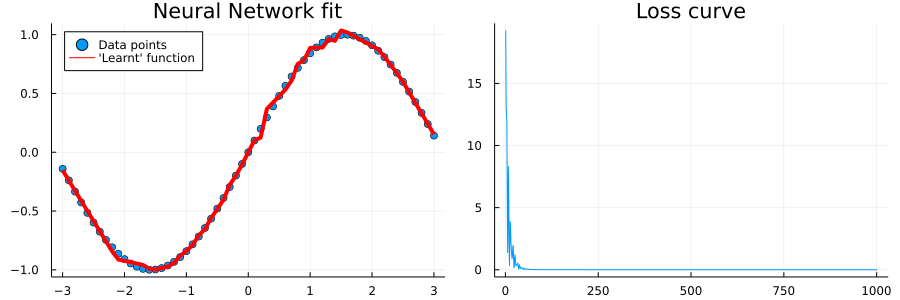

In [90]:
using Plots;
outputPlot = scatter(inputs, targetOutput,
    title = "Neural Network fit", label = "Data points", legend=:topleft
)
plot!(outputPlot, inputs, twoLayerNeuralNet(transpose(inputs))[:],
    label = "'Learnt' function", lw = 4, color = :red
)

lossCurvePlot = plot(lossCurve, title = "Loss curve", legend=:none)

plot(
    outputPlot,
    lossCurvePlot,
    size = (900,300)
)